# Introduction to AirBorne's ETL Pipeline: Extraction, Load & Cache

This page present a series of examples for generation and retrieval of data from different sources.

In [1]:
# Setup the dependencies
using Pkg; Pkg.add("Suppressor"); using Suppressor: @suppress;
@suppress Pkg.add(url="https://github.com/JuDO-dev/AirBorne.jl#dev");
@suppress Pkg.add(["Random","LinearAlgebra","Plots"]);


    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


## Historical Data: NASDAQ & YahooFinance

This dataset is formed by the top 5 most traded companies according to NASDAQ in each sector as per 3rd August 2023, listed since 2016 from Jan 1st 2017 until Jan 1st 2022.

In [2]:
using DataFrames: groupby, combine
########################################################
###    Pick the 5 most traded companies per sector   ###
########################################################
using AirBorne.ETL.NASDAQ: screener
using AirBorne.Utils: get_latest_N
tickers_df = screener()
filtered_df =tickers_df[[   x!="" ? parse(Int64, x)<2016 : false for x in tickers_df.ipoyear],["symbol","marketCap","sector","volume"]]
filtered_df[!,"volume"]=parse.(Int64,filtered_df[!,"volume"])
filtered_df[!,"marketCap"]=parse.(Float64,filtered_df[!,"marketCap"])
grouped_df = groupby(filtered_df,"sector")
f(sdf)= get_latest_N(sdf,:volume,5;rev=true)
result = combine(grouped_df,f)

#####################################################
###    Extract interday date from Yahoo Finance   ###
#####################################################
using AirBorne.ETL.Cache: store_bundle
bundle_id="Mark1"
cache_dir = joinpath(@__DIR__, "data", "cache")
# To generate the "demo" data use:
using AirBorne.ETL.YFinance: get_interday_data
using AirBorne.ETL.Cache: store_bundle
using Dates: DateTime, datetime2unix
from = DateTime("2017-01-01"); to = DateTime("2022-01-01")
u_from = string(round(Int, datetime2unix(from)));
u_to = string(round(Int, datetime2unix(to)))
data = get_interday_data(result.symbol, u_from, u_to)
store_bundle(data; bundle_id=bundle_id, archive=true, cache_dir=cache_dir)
@info "Done!"
first(data,4)

[ Info: Done!


Row,close,high,low,open,volume,date,unix,exchangeName,timezone,currency,symbol,assetID
,Float64,Float64,Float64,Float64,Int64,DateTime,Int64,String,String,String,String,String
1,58.78,58.92,58.13,58.92,909100,2017-01-03T10:30:00,1483453800,NYQ,America/New_York,USD,SPR,NYQ/SPR
2,59.66,60.11,58.8,58.96,1326600,2017-01-04T10:30:00,1483540200,NYQ,America/New_York,USD,SPR,NYQ/SPR
3,60.04,60.92,59.64,59.85,1133900,2017-01-05T10:30:00,1483626600,NYQ,America/New_York,USD,SPR,NYQ/SPR
4,59.78,60.12,59.47,59.78,850900,2017-01-06T10:30:00,1483713000,NYQ,America/New_York,USD,SPR,NYQ/SPR


In [7]:
# If you already have the data somewhere accessible by the cache loading the data directly is faster
using AirBorne.ETL.Cache: load_bundle
bundle_id="Mark1"
cache_dir = joinpath(@__DIR__, "data", "cache")
data=load_bundle(bundle_id;cache_dir=cache_dir)
first(data,4)

Row,close,high,low,open,volume,date,unix,exchangeName,timezone,currency,symbol,assetID
,Float64,Float64,Float64,Float64,Int64,DateTime,Int64,String,String,String,String,String
1,58.78,58.92,58.13,58.92,909100,2017-01-03T10:30:00,1483453800,NYQ,America/New_York,USD,SPR,NYQ/SPR
2,59.66,60.11,58.8,58.96,1326600,2017-01-04T10:30:00,1483540200,NYQ,America/New_York,USD,SPR,NYQ/SPR
3,60.04,60.92,59.64,59.85,1133900,2017-01-05T10:30:00,1483626600,NYQ,America/New_York,USD,SPR,NYQ/SPR
4,59.78,60.12,59.47,59.78,850900,2017-01-06T10:30:00,1483713000,NYQ,America/New_York,USD,SPR,NYQ/SPR


### Asset Valuation 
This submodules provides tools to transform raw from AirBorne sources in OHLCV format (open high low close volume) to calculate individual assets returns and their value.


#### Step 1: Asset Valuation
In this section the batch of OHLCV data first will be valuated and then based on the value of each individual asset the returns per asset will be produced.

Is worth noticing that the data generated does not have a dollar or any currency included, so if you want you can manually introduce the values of assets not included during the extraction stage 

In [10]:
using AirBorne.ETL.AssetValuation: stockValuation
sv=stockValuation(data)
sv[!,"FEX/USD"].=1.0 # Include the value of the Foreign Exchange dollar in the valuation, since all the figures are in dollars this just takes the value of 1.
first(sv,4)

Row,date,NYQ/SPR,NYQ/CNHI,NMS/PACB,NMS/AMRS,NYQ/TGI,NMS/TSLA,NMS/AMZN,NYQ/CCL,NMS/AMSC,NMS/JBLU,NMS/NVDA,NMS/AAPL,NYQ/NOK,NMS/MSFT,NMS/GOOGL,NMS/AGNC,NYQ/MPW,NYQ/DEI,NYQ/HPP,NYQ/BRX,NYQ/WRK,NCM/WSC,NYQ/AGI,NYQ/QSR,ASE/IMO,NCM/TTOO,NGM/ARDX,NMS/KDNY,NGM/ESPR,NYQ/TDOC,NYQ/MET,NMS/CG,NYQ/CFG,NGM/ARCC,NYQ/ALLY,NYQ/ABEV,NMS/SFM,NYQ/BG,NCM/TWNK,NYQ/DAR,NYQ/KMI,NMS/INFN,NYQ/TRGP,NMS/CLNE,NYQ/CIEN,NCM/PLUG,NYQ/DVN,NYQ/AR,NYQ/KOS,NYQ/WTI,NMS/CSCO,NMS/DISH,NMS/EXTR,NYQ/TEF,NMS/FFIV,NYQ/CCJ,NYQ/KGC,NYQ/RIO,NYQ/BVN,NYQ/EVA,NMS/RUN,NYQ/ENR,NGM/ULBI,NCM/JYNT,stockValue,FEX/USD
,DateTime,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Dict…,Float64
1,2017-01-03T10:30:00,58.78,8.69,4.36,11.25,27.1,14.466,37.6835,52.14,7.42,22.39,25.5025,29.0375,4.77,62.58,40.4005,18.57,12.43,36.75,34.94,24.5,51.22,9.9,7.26,47.0,35.03,261.5,14.55,56.5,12.88,16.5,48.3779,15.6,35.86,16.42,19.23,5.07,19.49,73.24,13.0,13.4,21.61,8.72,57.98,3.09,24.43,1.21,47.08,23.68,7.25,2.85,30.54,59.69,5.18,9.32,144.8,10.4,3.29,38.96,12.01,26.75,5.59,46.01,4.93,2.65,"Dict(""NYQ/BVN""=>12.01, ""NMS/INFN""=>8.72, ""NCM/TTOO""=>261.5, ""NMS/CLNE""=>3.09, ""NMS/SFM""=>19.49, ""NGM/ULBI""=>4.93, ""NMS/JBLU""=>22.39, ""NYQ/CFG""=>35.86, ""NYQ/KMI""=>21.61, ""NMS/PACB""=>4.36…)",1.0
2,2017-01-04T10:30:00,59.66,8.67,4.59,11.7,28.6,15.1327,37.859,52.82,7.41,22.65,26.0975,29.005,4.84,62.3,40.3885,18.9,12.48,37.53,35.37,24.92,51.99,9.9,7.5,47.95,35.23,267.5,14.45,59.75,13.89,16.5,48.6453,16.05,36.17,16.97,19.7,5.11,19.49,72.27,12.93,13.47,21.72,8.91,58.27,3.23,24.74,1.3,47.5,24.63,7.21,2.94,30.1,60.39,5.17,9.33,145.46,10.69,3.29,39.21,12.69,27.2,5.82,47.18,4.95,2.66,"Dict(""NYQ/BVN""=>12.69, ""NMS/INFN""=>8.91, ""NCM/TTOO""=>267.5, ""NMS/CLNE""=>3.23, ""NMS/SFM""=>19.49, ""NGM/ULBI""=>4.95, ""NMS/JBLU""=>22.65, ""NYQ/CFG""=>36.17, ""NYQ/KMI""=>21.72, ""NMS/PACB""=>4.59…)",1.0
3,2017-01-05T10:30:00,60.04,8.94,4.81,11.85,26.95,15.1167,39.0225,53.71,7.24,22.27,25.435,29.1525,4.9,62.3,40.651,18.94,12.54,36.82,35.25,25.29,52.23,10.0,8.56,48.3,34.88,259.5,12.95,60.5,13.61,16.4,47.9768,16.3,35.72,16.7,19.72,5.16,19.55,71.1,13.04,13.31,21.69,8.79,58.99,3.14,24.3,1.26,49.01,24.89,7.08,2.91,30.17,60.76,5.15,9.66,144.42,10.93,3.46,39.32,13.03,27.2,5.81,47.6,5.2,2.79,"Dict(""NYQ/BVN""=>13.03, ""NMS/INFN""=>8.79, ""NCM/TTOO""=>259.5, ""NMS/CLNE""=>3.14, ""NMS/SFM""=>19.55, ""NGM/ULBI""=>5.2, ""NMS/JBLU""=>22.27, ""NYQ/CFG""=>35.72, ""NYQ/KMI""=>21.69, ""NMS/PACB""=>4.81…)",1.0
4,2017-01-06T10:30:00,59.78,8.94,4.85,12.15,26.65,15.2673,39.7995,53.65,7.35,21.83,25.775,29.4775,4.92,62.84,41.2605,18.87,12.53,36.87,35.24,25.27,52.49,10.0,7.95,49.47,34.96,253.5,13.85,59.5,13.78,16.55,48.2888,16.65,35.91,16.91,19.89,5.09,19.51,70.14,13.02,13.2,21.81,8.84,59.41,3.06,24.2,1.25,48.67,24.68,7.08,3.19,30.23,61.36,5.28,9.65,144.45,10.77,3.35,38.39,12.58,27.7,5.8,47.71,5.21,2.78,"Dict(""NYQ/BVN""=>12.58, ""NMS/INFN""=>8.84, ""NCM/TTOO""=>253.5, ""NMS/CLNE""=>3.06, ""NMS/SFM""=>19.51, ""NGM/ULBI""=>5.21, ""NMS/JBLU""=>21.83, ""NYQ/CFG""=>35.91, ""NYQ/KMI""=>21.81, ""NMS/PACB""=>4.85…)",1.0


#### Step 2: Asset returns calculation
To calculate the asset valuation of a given day one can simply report the incremental gain proportional to the value before, this is the default approach. Since for the first day there is not a previous value, the returns function returns a 0. This is done in order to keep the number of rows between the dataframe of the valuation identical to the one of the returns for size consistency purposes.

In [8]:
# Step 2: Calculate the returns
using AirBorne.ETL.AssetValuation: stockValuation, returns
sr=returns(sv)
first(sr,4)

Row,date,NYQ/SPR,NYQ/CNHI,NMS/PACB,NMS/AMRS,NYQ/TGI,NMS/TSLA,NMS/AMZN,NYQ/CCL,NMS/AMSC,NMS/JBLU,NMS/NVDA,NMS/AAPL,NYQ/NOK,NMS/MSFT,NMS/GOOGL,NMS/AGNC,NYQ/MPW,NYQ/DEI,NYQ/HPP,NYQ/BRX,NYQ/WRK,NCM/WSC,NYQ/AGI,NYQ/QSR,ASE/IMO,NCM/TTOO,NGM/ARDX,NMS/KDNY,NGM/ESPR,NYQ/TDOC,NYQ/MET,NMS/CG,NYQ/CFG,NGM/ARCC,NYQ/ALLY,NYQ/ABEV,NMS/SFM,NYQ/BG,NCM/TWNK,NYQ/DAR,NYQ/KMI,NMS/INFN,NYQ/TRGP,NMS/CLNE,NYQ/CIEN,NCM/PLUG,NYQ/DVN,NYQ/AR,NYQ/KOS,NYQ/WTI,NMS/CSCO,NMS/DISH,NMS/EXTR,NYQ/TEF,NMS/FFIV,NYQ/CCJ,NYQ/KGC,NYQ/RIO,NYQ/BVN,NYQ/EVA,NMS/RUN,NYQ/ENR,NGM/ULBI,NCM/JYNT,FEX/USD,stockReturns
,DateTime,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Union…,Dict…
1,2017-01-03T10:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Dict(""NYQ/BVN""=>0.0, ""NMS/INFN""=>0.0, ""NCM/TTOO""=>0.0, ""NMS/CLNE""=>0.0, ""NMS/SFM""=>0.0, ""NGM/ULBI""=>0.0, ""NMS/JBLU""=>0.0, ""NYQ/CFG""=>0.0, ""NYQ/KMI""=>0.0, ""NMS/PACB""=>0.0…)"
2,2017-01-04T10:30:00,0.0149711,-0.00230144,0.0527523,0.04,0.0553506,0.0460851,0.00465728,0.0130418,-0.00134774,0.0116123,0.023331,-0.00111928,0.0146751,-0.00447431,-0.000297052,0.0177706,0.00402246,0.0212245,0.0123068,0.0171429,0.0150332,0.0,0.0330578,0.0202128,0.00570941,0.0229446,-0.00687288,0.0575221,0.0784162,0.0,0.0055269,0.0288461,0.00864466,0.0334957,0.024441,0.00788954,0.0,-0.0132441,-0.00538459,0.00522393,0.00509018,0.0217889,0.00500174,0.0453075,0.0126893,0.0743801,0.00892095,0.0401182,-0.00551724,0.031579,-0.0144074,0.0117273,-0.00193045,0.00107299,0.00455804,0.0278846,0.0,0.00641684,0.0566194,0.0168225,0.0411449,0.0254293,0.00405679,0.00377358,0.0,"Dict(""NYQ/BVN""=>0.0566194, ""NMS/INFN""=>0.0217889, ""NCM/TTOO""=>0.0229446, ""NMS/CLNE""=>0.0453075, ""NMS/SFM""=>0.0, ""NGM/ULBI""=>0.00405679, ""NMS/JBLU""=>0.0116123, ""NYQ/CFG""=>0.00864466, ""NYQ/KMI""=>0.00509018, ""NMS/PACB""=>0.0527523…)"
3,2017-01-05T10:30:00,0.00636944,0.0311418,0.0479302,0.0128206,-0.0576923,-0.0010573,0.0307324,0.0168497,-0.022942,-0.016777,-0.0253856,0.00508536,0.0123967,0.0,0.00649939,0.00211645,0.00480773,-0.0189182,-0.00339268,0.0148475,0.00461623,0.010101,0.141333,0.00729924,-0.00993467,-0.0299065,-0.103806,0.0125523,-0.0201584,-0.00606063,-0.0137413,0.0155763,-0.0124412,-0.0159103,0.00101515,0.00978468,0.00307847,-0.0161893,0.00850732,-0.0118782,-0.00138116,-0.013468,0.0123563,-0.0278638,-0.017785,-0.0307692,0.0317894,0.0105562,-0.0180305,-0.0102041,0.00232557,0.00612682,-0.00386847,0.0353698,-0.00714979,0.022451,0.0516718,0.00280542,0.0267928,0.0,-0.00171825,0.00890204,0.0505051,0.0488721,0.0,"Dict(""NYQ/BVN""=>0.0267928, ""NMS/INFN""=>-0.013468, ""NCM/TTOO""=>-0.0299065, ""NMS/CLNE""=>-0.0278638, ""NMS/SFM""=>0.00307847, ""NGM/ULBI""=>0.0505051, ""NMS/JBLU""=>-0.016777, ""NYQ/CFG""=>-0.0124412, ""NYQ/KMI""=>-0.00138116, ""NMS/PACB""=>0.0479302…)"
4,2017-01-06T10:30:00,-0.00433048,0.0,0.008316,0.0253164,-0.0111318,0.0099669,0.0199116,-0.00111706,0.0151934,-0.0197575,0.0133674,0.0111483,0.00408163,0.00866775,0.0149935,-0.00369587,-0.000797466,0.00135794,-0.00028364,-0.000790844,0.00497802,0.0,-0.0712618,0.0242236,0.00229352,-0.0231214,0.0694981,-0.0165289,0.0124908,0.00914632,0.00650195,0.0214724,0.00531911,0.0125748,0.00862069,-0.0135658,-0.00204599,-0.0135021,-0.0015337,-0.00826451,0.00553245,0.0056883,0.00711982,-0.0254778,-0.00411516,-0.0079365,-0.00693736,-0.00843709,0.0,0.0962199,0.00198871,0.00987496,0.0252427,-0.00103522,0.000207719,-0

## Synthetic Data: The ARMAX Model

This model  **A**uto**R**egressive **M**oving **A**verage e**X**ogeneous(ARMAX) model is a Linear Time Invariant system governed by the following transfer function.

$$A(z) y(t) = C(z) e(t) + B(z) u(t)$$

- $y$: System Output
- $e$: Non-deterministic Noise
- $u$: System Input
- $A(z) = 1 + a_1 z^{-1} + a_2 z^{-2} ... $ 
- $B(z) = b_0 + b_1 z^{-1} + b_2 z^{-2} ... $ 
- $C(z) = c_0 + c_1 z^{-1} + c_2 z^{-2} ... $ 

Leaving the time difference equation:

$$ y(t) = -\left(a_1 y(t-1) + a_2 y(t-2) +... +a_{na} y(t-na)\right)+... \\
c_0 * e(t) + c_1 * e(t-1)+ ... +  c_{nc} * e(t-nc)+ ... \\  
b_0 * u(t) + b_1 * u(t-1)+ ... +  b_{nb} * u(t-nb)  $$ 

- $u \in R^m$
- $y \in R^p $

For simplicity in this example we will focus on SISO systems, but the same equations apply to higher dimensional systems.

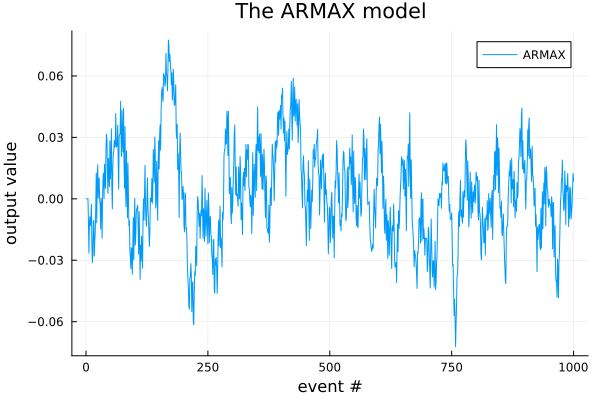

In [4]:
# ARMAX process generator
using Random: rand
using LinearAlgebra: dot
using Plots: plot

SimT=1000
na=3;nb=1;nc=3;
m=1;p=1;
# This model presents nice curves  
A_coeffs = [0.5, 0.25, 0.125]
B_coeffs = [0.40]
C_coeffs = [-0.21, -0.36, -0.013]

t=1:SimT
y = collect(t.*0.0) # Noise Generator
e = (rand(Float64, ( SimT)).-0.5)*0.1# Noise Generator
u = zeros(size(t) ) #rand(Float64, ( SimT)).-0.5 # Noise Generator
max_n = max(na,nb,nc)
for i in t
    y[i] = i>max_n ? dot(y[(i-na):(i-1)],A_coeffs) + dot(e[(i-nc+1):i],C_coeffs) + dot(u[(i-nb+1):i],B_coeffs) : 0
end

plot(t,y,xlabel="event #", ylabel="output value", title="The ARMAX model", label="ARMAX")
